# 08/05/15  Example of variational inference using Theano (for Markov Random Fields)!  

## Written by Andreas Damianou, James Hensman, Srijith Prabhakaran, Varvara Logacheva, Alan Saul, Zhenwen Dai

This is a simple example on using Theano to implement a simple probabilistic model. The greatest advantage of using Theano, is that we don't have to compute the analytic gradients for optimising the model. 

This notebook is indended to demonstrate the basic functionality, errors/bugs are likely to be present!! If you find bugs/errors, please contact one of the authors!


## Markov Random Fields

A Markov Random Field (MRF) is an undirected graphical model. We consider nodes in the graph to take values in the set $\{+1, -1\}$. A subset of these nodes are instantiations of the latent variable $\mathbf{x}$, and another subset are instantiations of the observed set $\mathbf{y}$. Both $x_i, y_i$ take values from $\{+1, -1\}$. We can equivalently write $\mathbf{x} \in \Re^{ND\times 1}$ as a matrix $\mathbf{X} \in \Re^{N \times D}$, in order to define neighbouring relationships between elements (e.g. $\mathbf{X}_{2,2}$ has as neighbours $\mathbf{X}_{1,2},\mathbf{X}_{2,1},\mathbf{X}_{2,3}$ and $\mathbf{X}_{3,2}$). Similarly for $\mathbf{y}$.

Sources:

1) Bishop's book (PRML), p. 383 

2) MacKay's book (Inf. Theory, Inference and learning algorithms), Variational Inference section (Ising model).


The energy function for the model is written as:
\begin{equation}
E(\mathbf{x}, \mathbf{y}) = h \sum_i x_i - \beta \sum_{\{i,j\}} x_i x_j - \eta \sum_i x_i y_i  \; \; \; \text{(1)}
\end{equation}
where $h,\beta,\eta$ are scalar parameters and $\{i,j\}$ in the second summation refers to nodes that are neighbours.

The joint distribution over $\mathbf{x}, \mathbf{y}$ given the parameters (omitted for clarity), is given from:

\begin{equation}
p( \mathbf{x}, \mathbf{y} ) = \frac{1}{Z} \exp{ \left(-E(\mathbf{x}, \mathbf{y})\right)}, \; \; \; \text{(2)}
\end{equation}
where $Z$ is the normalisation constant (known as partition function) obtained by summing over all possible values of $\mathbf{x}$.

Next, we will implement the energy function in Theano.

## Implementation of the energy function in Theano

In [1]:
# Import Theano
import theano
# Tensor is the most useful module to import for our purposes. Let's make a shorthand
from theano import tensor as T
# Let's import other useful libraries
import numpy as np
import scipy as sp 
import Image
import pylab as pb
%pylab inline

pb.ion()

Couldn't import dot_parser, loading of dot files will not be possible.
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Tip: if running Theano from the terminal through ipython, it might be helpful for debugging to open ipython using:

THEANO_FLAGS='optimize=None' ipython

Next we define the actual theano function. The expression to be evaluated (the energy function) is not trivially implemented in one line of code, therefore we might need intermediate variables. However, in the end all we're interested in, is the final symbolic expression for the energy function, and not the intermediate symbolic variables. Therefore, we might create the symbolic function within a python function:

In [11]:
def build_theano_energy_func():
    """ 
    All symbolic objects need to be declared with their type before being used.
    Here, imatrix is a matrix of integers, d of doubles etc
    """
    X = T.imatrix()
    Y = T.imatrix()
    b = T.dscalar()
    h = T.dscalar()
    e = T.dscalar()
    
    # Implement the second part of the energy function, requiring summation
    # over neighbours. A trick (thanks to J. Hensman!) is to do it by summing
    # the two "shifted" matrices by columns and rows to get partial sums, which
    # are then summed together
    sum_cols  = T.sum(X[:,:-1]*X[:,1:])
    sum_rows  = T.sum(X[:-1,:]*X[1:,:])
    sum_XX    = sum_cols + sum_rows
    
    # The last term of the energy function
    sumXY = T.sum(X*Y)
    
    # The first term plus everything put together
    energy_function = h*T.sum(X) - b*sum_XX - e*sumXY
    
    # The object to be returned is a theano function. Inputs to this function
    # are given as a list, and those are the latents, the observed and the
    # scalar paramters
    return theano.function([X,Y,b,h,e],energy_function,allow_input_downcast=True)


Let's test it:

In [12]:
# Create toy data
N = 10
D = 5

# Random values from the choice of -1,1
Yval  = np.random.choice([-1,1], (N,D))
Xval  = np.random.choice([-1,1], (N,D))
RSval = np.random.randn(N,D)
b_init = 1
h_init = 1
e_init = 1

In [13]:
f  = build_theano_energy_func()
f

Successful compilation is a good sign, but many errors actually occur during runtime. Let's call the function then:

In [14]:
f(Xval, Yval, b_init, h_init, e_init)

array(-7.0)

Seems to work!


## Mean-field variational inference



But to train the model, what we want is to not simply evaluate the energy function, but to find the posterior of the parameters given the data. The full posterior is $p(\mathbf{x}, \beta,h,\eta | \mathbf{y})$. However, to evaluate it we'd need to find the normalising constant $Z$. This is a very difficult problem, because evaluating $Z$ requires marginalisation over $\mathbf{x}$, i.e. averaging over all possible states for that variable. This cannot be achieved analytically, but instead we can resort to mean-field variational inference. For a certain type of approximating variational distributions, we can approximate the posterior for $\mathbf{x}$. However, to approximate the full posterior is not easy, because the partition function is a constant with respect to $\mathbf{x}$ (since it's marginalised out), but still includes $\beta, h, \eta$. 

Therefore, we will assume that these parameters are given and we will only focus on finding the approximate posterior $p(\mathbf{x} | \beta, h, \eta, \mathbf{y})$. We will also omit the dependence on $\beta, h, \eta$ further on, for clarity.



For a variational distribution $q(\mathbf{x})$, we want to find:
\begin{align}
  & \text{KL}(q(\mathbf{x}) || p(\mathbf{x} | \mathbf{y}) \\
= & \text{KL}\left( q(\mathbf{x}) || \frac{p(\mathbf{x} , \mathbf{y})}{p(\mathbf{y})} \right) \\
= & \langle \log q(\mathbf{x}) - \log p(\mathbf{x},\mathbf{y}) \rangle_{q(\mathbf{x})} + \log p(\mathbf{y}) \\
& \langle \log q(\mathbf{x}) + E(\mathbf{x},\mathbf{y}) \rangle_{q(\mathbf{x})} + \log Z +\log p(\mathbf{y})
\end{align}

To optimise this expression w.r.t. $\mathbf{x}$, we drop the two last terms that do not depend on it, and obtain our final objective:
\begin{equation}
\mathcal{F} = \langle \log q(\mathbf{x}) \rangle_{q(\mathbf{x})} + \langle E(\mathbf{x},\mathbf{y}) \rangle_{q(\mathbf{x})} \; \; \; \text{(3)}
\end{equation}

For this expression to be tractable, we select a variational distribution as a product of Bernoulli's:
\begin{equation}
q(\mathbf{x}) = \prod_i q(x_i) \; \; \; \text{(4)}
\end{equation}
where:

$q(x_i) = \rho_i,  \ \; \; \; \; \; \; \; $  if $x_i=+1$

$q(x_i) = (1-\rho_i)$, if $x_i=-1$

Given this distribution, the first term of $\mathcal{F}$ is simply:
\begin{equation}
 \langle \log q(\mathbf{x}) \rangle_{q(\mathbf{x})} = \rho_i \log \rho_i + (1-\rho_i) \log(1-\rho_i) \; \; \; \text{(5)}
\end{equation}

The second term is found by replacing the energy function $E(\mathbf{x},\mathbf{y})$ from eq. (1), and itself gives us three terms:


\begin{align}
\langle E(\mathbf{x},\mathbf{y}) \rangle_{q(\mathbf{x})} &= \langle h \sum_i x_i + \beta \sum_{\{i,j\}} x_i x_j + \eta \sum_i x_i y_i \rangle_{q(\mathbf{x})}  \\
&= h \sum_i (2\rho_i-1 ) + \beta \sum_{\{i,j\}} \left( (2\rho_i-1)(2\rho_j-1)\right) + \eta \sum_i (2\rho_i)y_i \; \; \; \text{(6)}
\end{align}

Replacing eq. 5,6) into (3), we get the final bound, which we will write with two indexes to facilitate translation into python. Specifically, the $c$ and $r$ are used to denote any consistent way of summing over all columns and rows of a matrix $\mathbf{R}$ which contains the variational parameters. The matrix notation comes from the fact that $\mathbf{R}$ can be stored as an $N \times D$ matrix instead of a long $ND \times 1$ vector. Further, $\{ i,j \}$ denotes neighbouring elements, as before. Therefore, we have:

\begin{align}
\mathcal{F} &= \sum_{c,r} \left[ \rho_{c,r} \log \rho_{c,r} + (1-\rho_{c,r}) \log( 1-\rho_{c,r}) + (h+\eta y_{c,r})(2 \rho_{c,r}-1) \right] \\
& + \beta \sum_{\{i,j\}} (2\rho_i-1)(2\rho_j-1) \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \text{(7)}
\end{align}

And here's how to implement this in Theano:

In [16]:
def build_expected_energy_func():
    # Declare all the variables to be used.
    
    # N and D are given as parameters, so that we know how to reshape RV
    N  = T.iscalar()
    D  = T.iscalar()
    # RV is the vector of \rho's, serialised with shape NDx1
    RV = T.dvector()
    Y  = T.imatrix()
    b  = T.dscalar()
    h  = T.dscalar()
    e  = T.dscalar()
    
    # RS is RV reshaped into a matrix (which makes the neighbouring connections clear)
    RS = T.reshape(RV, (N,D))
    
    # R must have entries between 0 and 1. This can be forced by having RS to be free
    # parameters and push them through a sigmoid.
    R = T.nnet.sigmoid(RS)

    # This computation is for eq. (7), using the same trick as for the energy function.
    sum_ij = T.sum(R*T.log(R) + (1-R) * T.log(1-R) + (h + e*Y)*(2*R-1))
    sum_ij_neighbor_cols = T.sum((2*R[:,:-1]-1)*(2*R[:,1:]-1))
    sum_ij_neighbor_rows = T.sum((2*R[:-1,:]-1)*(2*R[1:,:]-1))
    sum_ij_neighbor = sum_ij_neighbor_rows + sum_ij_neighbor_cols

    expected_energy_function = sum_ij + b*sum_ij_neighbor

    # first part are inputs to the built function. Then a list of outputs. Our function 
    # will return as outputs the objective and the gradients.
    return theano.function([RV,Y,b,h,e, N, D],[expected_energy_function, theano.grad(expected_energy_function,RV)],allow_input_downcast=True)


As can be seen, once we implement the objective, then the gradient can be simply returned by calling one more function! Another trick used, is to represent the parameters separately in the optimiser and separately internally. Specifically, the optimiser sees a vector of real values, and the programme then transforms them to a matrix of elements in [0,1], firstly through a reshaping and then through pushing through the sigmoid.\

Test the syntax:

In [17]:
Ef = build_expected_energy_func()

Test running it:

In [18]:
Ef(RSval.flatten(), Yval, b_init, h_init, e_init, N, D)

options = dict()
options['disp']=True

res=sp.optimize.minimize(Ef, RSval.flatten(), (Yval, b_init, h_init, e_init, N, D), jac=True, options=options)#, bounds=optBounds)

optimised_params = res['x']

Optimization terminated successfully.
         Current function value: -86.039966
         Iterations: 412
         Function evaluations: 455
         Gradient evaluations: 455


It works! Now let's move to an application.


## Image denoising

We'll attempt to use the MRF as an image denoiser, as in Bishop's book. To begin with, we'll load the image of the the incredibly complex flag of Japan:

In [19]:
import urllib, cStringIO
URL='http://upload.wikimedia.org/wikipedia/en/thumb/9/9e/Flag_of_Japan.svg/1280px-Flag_of_Japan.svg.png'
file = cStringIO.StringIO(urllib.urlopen(URL).read())
img = Image.open(file).convert('L')

We can optionally reshape the image. We will also "binarize" it.

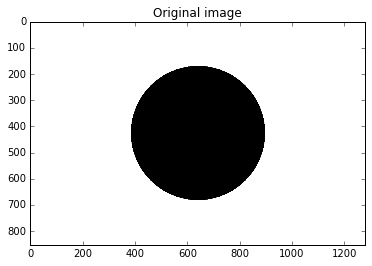

In [20]:
im_reshape=False

if im_reshape:
    perc=.25
    im = np.asarray(img)
    N,D = im.shape
    img = img.resize((int(np.ceil(D*perc)),int(np.ceil(N*perc))),Image.ANTIALIAS)
    im = np.asarray(img)
    N,D = im.shape
else:
    im = np.asarray(img)
    N,D = im.shape

# Normalise pixel values between 0 and 1
im = im / 255.

# Shift spectrum from 0,1 to -1, 1
im = np.where(im < 0.4, -1, 1)

pb.imshow(im,cmap=pb.cm.gray)
pb.title('Original image')
pb.show()


We'll add noise to the picture (20% noise, feel free to change the parameters). 
Then, we'll initlise the R parameters. One way to do it, is based on the data. There are other suggested ways (commented out), feel free to explore.

The parameters are hardcoded and suboptimal, you can try different values too.

In [21]:
# Noise is added randomly at 20% of pixels.
noise = np.random.rand(N,D)
noise = np.where(noise > 0.8, -1, 1)

Yval = im * noise

# Initialise the R parameters.
RSval = Yval #np.ones_like(Yval)*0.5#Yval # np.random.randn(N,D)  # Init

b_init = -50
h_init = 0
e_init = 2.1

Ef = build_expected_energy_func()

Ef(RSval.flatten(), Yval, b_init, h_init, e_init, N, D)

options = dict()
options['disp']=True
options['maxiter']=300

# This is a bit buggy, sometimes the output is displayed in the terminal instead of inline here...
res=sp.optimize.minimize(Ef, RSval.flatten(), (Yval, b_init, h_init, e_init, N, D), jac=True, method='L-BFGS-B', options=options )


KeyboardInterrupt: 

Now display the results.

In [ ]:
fig = pb.figure(figsize=(15,12))
fig1=fig.add_subplot(121)
fig1.matshow(Yval,cmap=pb.cm.gray)
pb.title('Noisy image')

RSVopt = res['x']
A = T.dmatrix()
sig = theano.function([A], T.nnet.sigmoid(A))
Ropt = sig(RSVopt.reshape(N,D))

fig2=fig.add_subplot(122)
fig2.matshow(Ropt, cmap=pb.cm.gray)
pb.title('Cleaned image')
